## Business Understanding
Music is a part of most people’s lives, whether in the context of workouts, cocktails, night clubs, or TV and movies. But only certain types of music work in certain situations. I like to think of this as ‘Genre Fit’ or ‘Appropriateness’. Music isn’t just good or bad; It’s good or bad for a situation. The Game of Thrones intro is great, but it probably wouldn’t mix very well with a SitCom or a cocktail party. On a narrower spectrum, for one person’s wedding reception Country music might be great and Classical would be uncomfortable. For a different person’s wedding reception the opposite might be true. Luckily we often have Genre labels for music. What about new music? Likely artists will self report the genre. But what if a Folk artist produces a Jazz song? Or what we want to find the Folk songs that are also Jazz, but some of them are labeled as Folk and some of them are labeled as Jazz? Or for another genres example, what if we wanted to find new Country music that is no way Hip Hop? If we can predict the likelihood that a song falls into certain genres we can answer these questions.

## Data Understaning
__Collection__- For this experiment, about 100 songs worth of data are collect from each genre. In total 10 genres are collected. This experiment is intended to be quickly repeatable with different mixes and numbers of genres of music. So If you’d like to re-run this experiment with different genres, you can just replace the playlist urls with other playlists and genre labels.  
In a previous experiment, 6 genres were collected and will joined with new features.

For each genre a playlist on youtube is selected, such as a ‘Top 100 country’, effectively pre-labeling the data. The urls to each song are collected using BeautifulSoup. Then for each song, the audio file is retrieved using the youtube_dl library. The audio file is then loaded as 1d numpy array, using the librosa audio library. If the song is longer than 4 minutes only the first 4 minutes are loaded. The song’s audio is then chopped into 10-second pieces for a more granular examination of the sounds present. Librosa is then used to extract features such as tempo, spectral centroid, spectral rolloff, zero crossing rate and mel frequency cepstral coefficients. These terms are very jargon-ey but in essence, they represent parts of the timbre of a sound. They are then averaged over their 10-second intervals to create 1 data point per feature. The features are then stored in a json with the genre label and one row for each 10-second chunk in the song. The audio file is then erased before moving on to the next song. The same process is repeated for each song of each genre.

In [130]:
import pandas as pd
import numpy as np

%load_ext autoreload
%autoreload 2

from genres import collect_genre_features

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
genre_playlists = {
    'bluegrass':'https://www.youtube.com/playlist?list=PLKUA473MWUv2mddNMPh-MJkgTR5AjTpl3',
    'blues':'https://www.youtube.com/playlist?list=PLxvodScTx2RuB7Yh_d21kD0HDZvDXWBbY',
    'folk':'https://www.youtube.com/playlist?list=PLGBuKfnErZlBLNzS_JlDAeiH5aW26rvHc',
    'classic_rock':'https://www.youtube.com/playlist?list=PLNxOe-buLm6cz8UQ-hyG1nm3RTNBUBv3K'
}
# collect_genre_features(genre_playlists, data_fp='data/extra_genre_features.json')

In [5]:
df_extra = pd.read_json('data/extra_genre_features.json', lines=True)

In [7]:
df_extra.groupby('genre').song.count()

genre
bluegrass       2083
blues           2206
classic_rock    1920
folk            1773
Name: song, dtype: int64

In [6]:
df_extra.groupby('genre').song.nunique()

genre
bluegrass       87
blues           92
classic_rock    80
folk            74
Name: song, dtype: int64

Not perfect but a reasonable chunk.

### Lets Pickle them for storage on GitHub.

In [8]:
import pickle

In [9]:
with open('data/extra_genre_features.pkl', 'wb') as f:
    pickle.dump(df_extra.to_json(), f)

In [10]:
df_original = pd.read_json('data/genre_features.json', lines=True)

In [11]:
with open('data/genre_features.pkl', 'wb') as f:
    pickle.dump(df_original.to_json(), f)

### Data Preparation

Putting the old with the new.

In [12]:
with open('data/genre_features.pkl', 'rb') as f:
    df_original = pd.read_json(pickle.load(f))
with open('data/extra_genre_features.pkl', 'rb') as f:
    df_extra = pd.read_json(pickle.load(f))

In [134]:
df = pd.concat([df_original, df_extra])

In [168]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22203 entries, 0 to 7981
Data columns (total 22 columns):
song           22203 non-null object
genre          22203 non-null object
tempo          22203 non-null float64
beats          22203 non-null int64
chroma_stft    22203 non-null float64
rms            22203 non-null float64
spec_cent      22203 non-null float64
spec_bw        22203 non-null float64
rolloff        22203 non-null float64
zcr            22203 non-null float64
mfcc1          22203 non-null float64
mfcc2          22203 non-null float64
mfcc3          22203 non-null float64
mfcc4          22203 non-null float64
mfcc5          22203 non-null float64
mfcc6          22203 non-null float64
mfcc7          22203 non-null float64
mfcc8          22203 non-null float64
mfcc9          22203 non-null float64
mfcc10         22203 non-null float64
mfcc11         22203 non-null float64
mfcc12         22203 non-null float64
dtypes: float64(19), int64(1), object(2)
memory usage: 4.5+ 

The next visualization is going to look messy, but it should identify columns with little differences between genres that might not provide as much information.

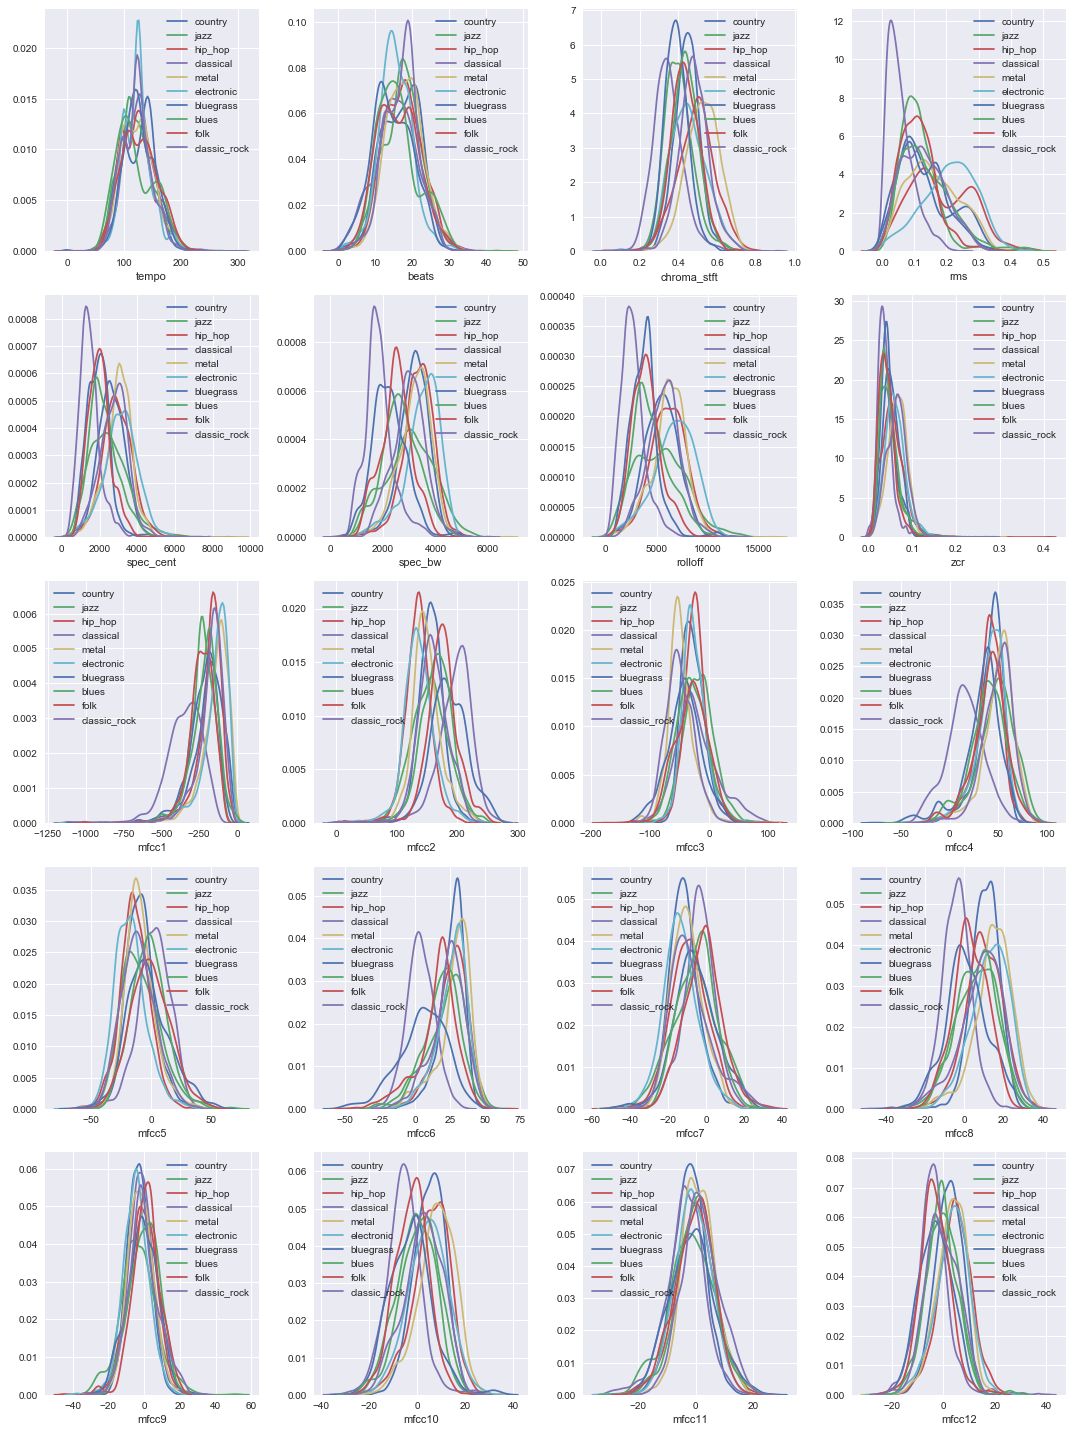

In [181]:
genres_to_viz = df.genre.unique()
# genres_to_viz = ['jazz', 'classical']
plt.figure(figsize=(15,20))
for n, feature in enumerate(df.select_dtypes(['float', 'int']), 1):
    plt.subplot(5,4,n)
    for genre in genres_to_viz:
        sns.distplot(df.loc[df.genre == genre, feature], hist=None, label=genre)
    plt.legend()
    n+=1
plt.tight_layout()

Mfcc's 9 and 11 seem to have vary few distinct genres. Lets explore them more closely.

This is also an overwhelming collection of images, but notice consistent the mfcc9 and 11 features are among genres.

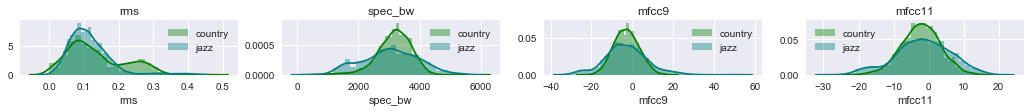

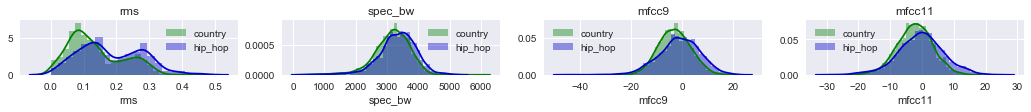

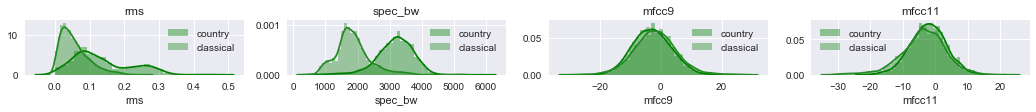

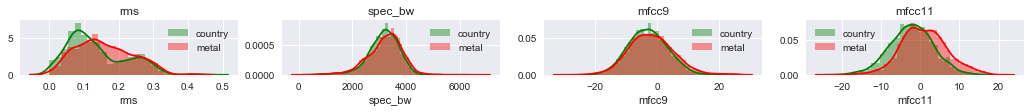

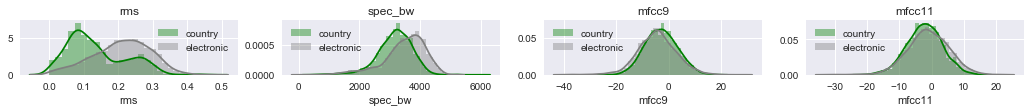

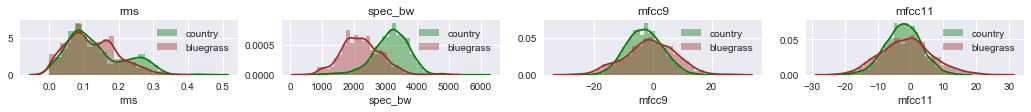

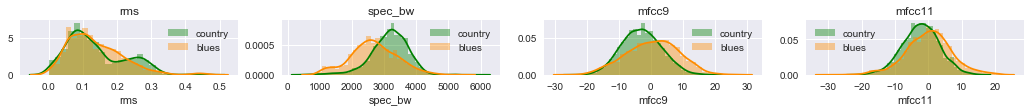

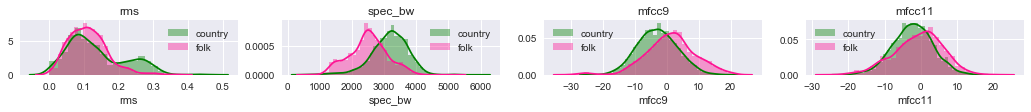

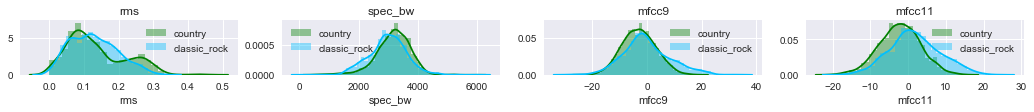

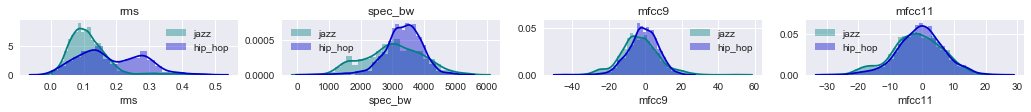

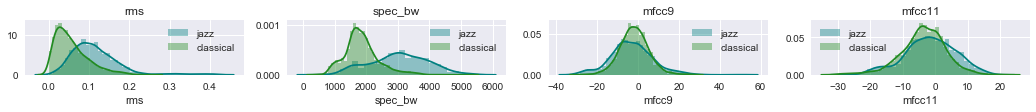

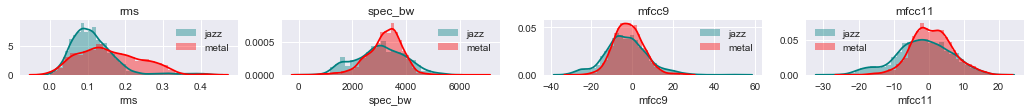

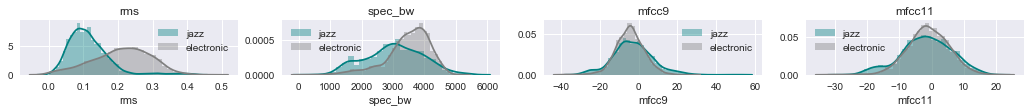

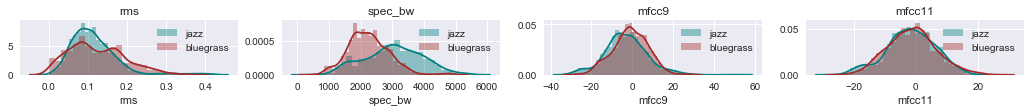

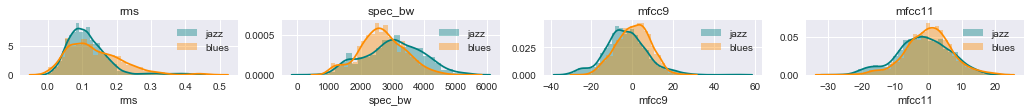

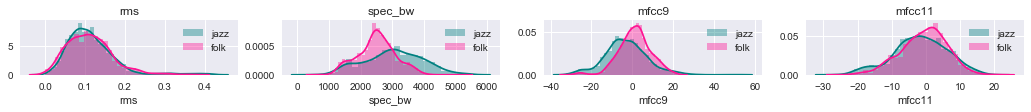

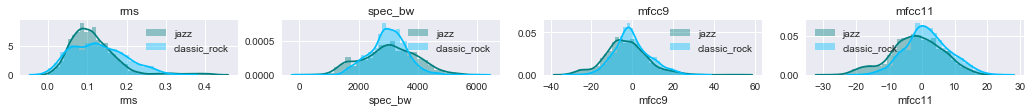

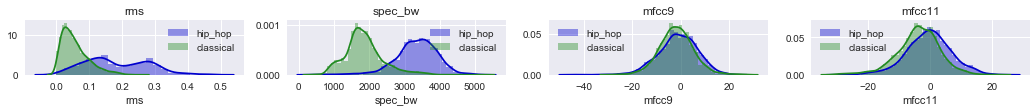

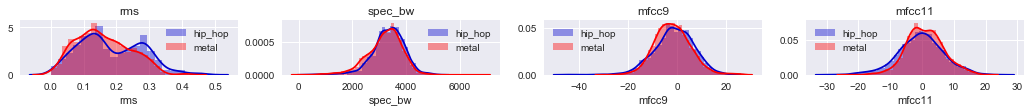

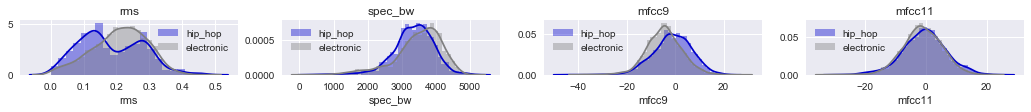

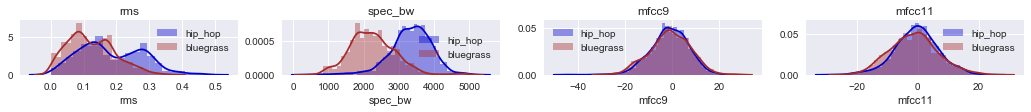

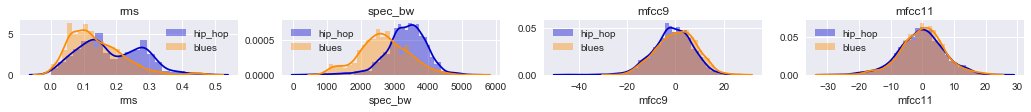

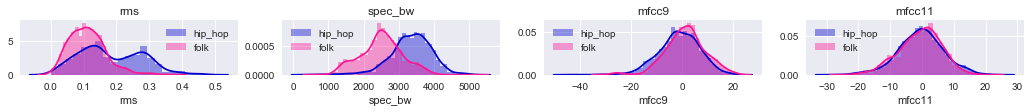

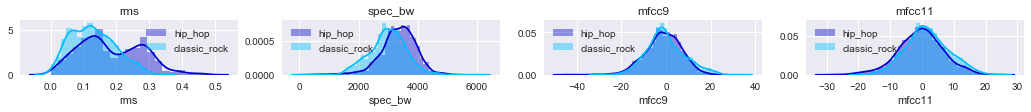

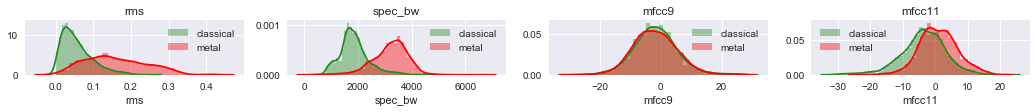

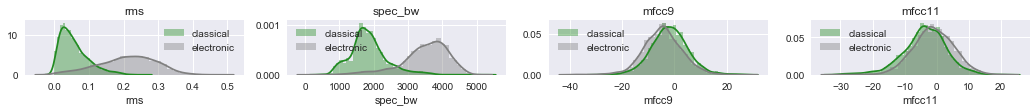

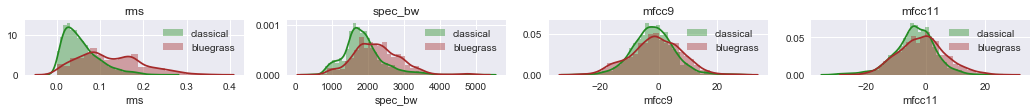

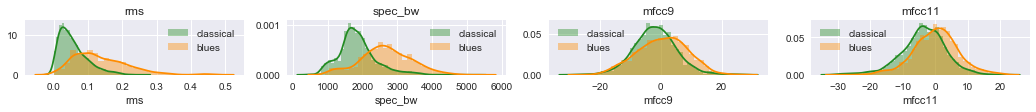

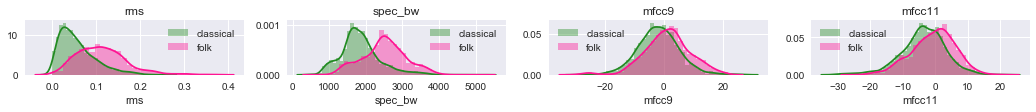

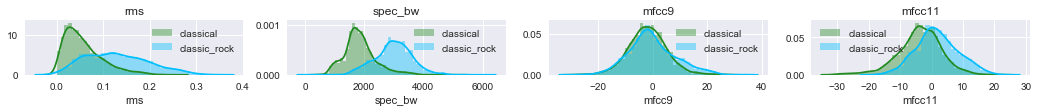

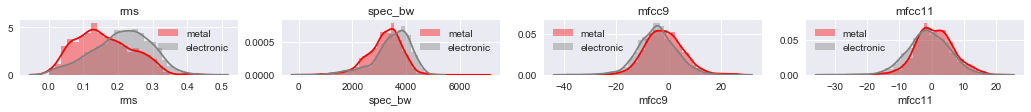

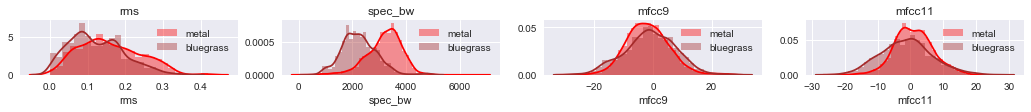

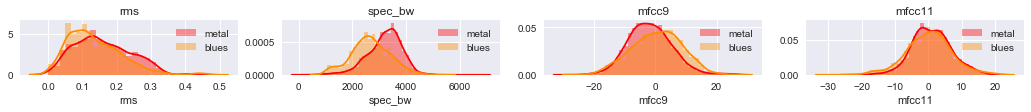

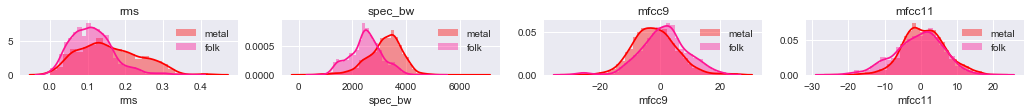

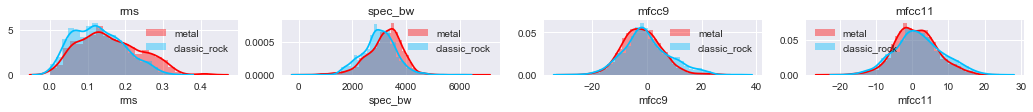

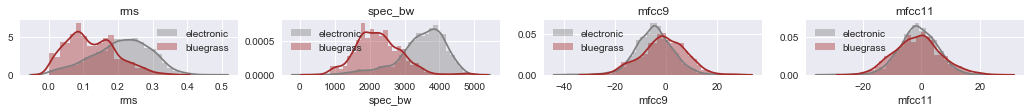

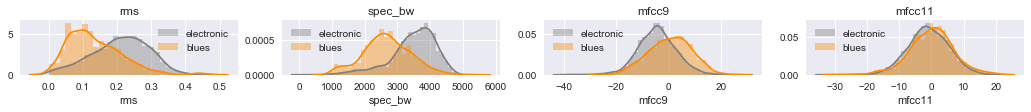

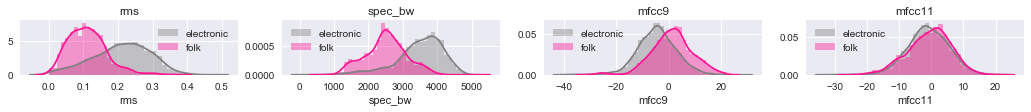

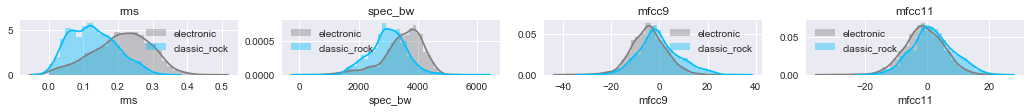

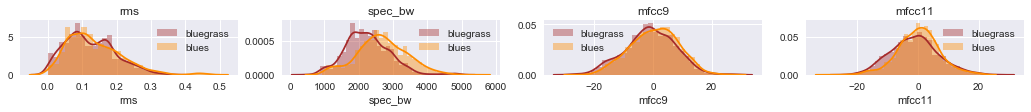

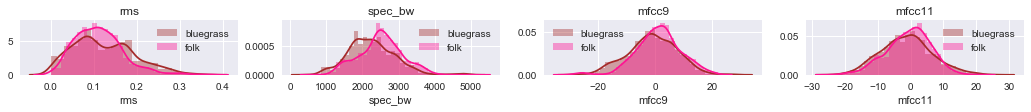

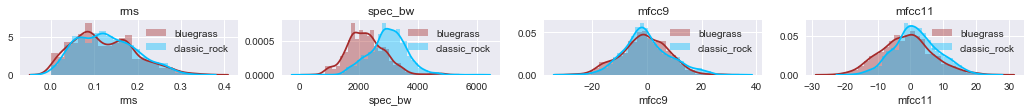

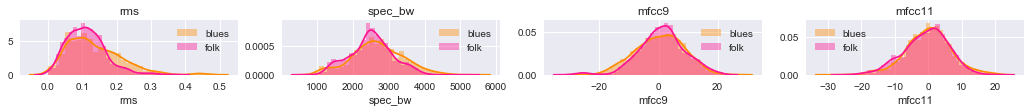

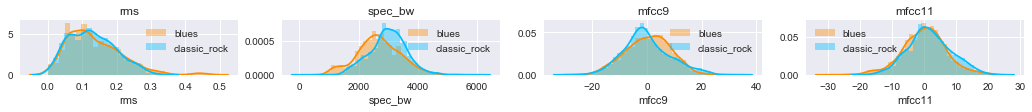

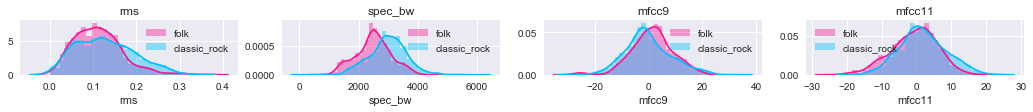

In [207]:
cols = ['rms', 'spec_bw', 'mfcc9', 'mfcc11']
colors={
    genre:color for genre, color in zip(df.genre.unique(),[
        'green', 'teal', 'mediumblue', 'forestgreen', 'red',
        'gray', 'brown', 'darkorange', 'deeppink', 'deepskyblue'
    ])
}
for g1, g2 in itertools.combinations(df.genre.unique(), 2):
    plt.figure(figsize=(18,1))
    for i, col in enumerate(cols, start=1):
        plt.subplot(1, len(cols), i)
        s1 = df.loc[df.genre == g1, col]
        s2 = df.loc[df.genre == g2, col]
        sns.distplot(s1, label=g1, color=colors[g1])
        sns.distplot(s2, label=g2, color=colors[g2])
        plt.title(col)
        plt.legend()
    plt.show()

Mfcc's 9 and 11 may be candidates to drop and see if the model performs anybetter.

### Train Test Validation Splitting

In [14]:
from sklearn.model_selection import train_test_split

y = df['genre']
X = df.drop(['genre', 'song'], axis=1)
X_model, X_val, y_model, y_val = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=111,
    stratify=y
)
X_train, X_test, y_train, y_test = train_test_split(
    X_model,
    y_model,
    test_size=0.2,
    random_state=111,
    stratify=y_model
)

In [15]:
y.value_counts()

metal           2399
jazz            2397
country         2389
electronic      2371
hip_hop         2345
classical       2320
blues           2206
bluegrass       2083
classic_rock    1920
folk            1773
Name: genre, dtype: int64

In [16]:
tt_split_dists = pd.concat(
    [
        y_train.value_counts(sort=False),
        y_test.value_counts(sort=False),
        y_val.value_counts(sort=False)
    ],
    axis=1,
    sort=False
)
tt_split_dists

,genre,genre,genre
classic_rock,1229,307,384
classical,1485,371,464
metal,1535,384,480
electronic,1517,380,474
bluegrass,1333,333,417
country,1529,382,478
hip_hop,1501,375,469
blues,1412,353,441
folk,1134,284,355
jazz,1534,384,479


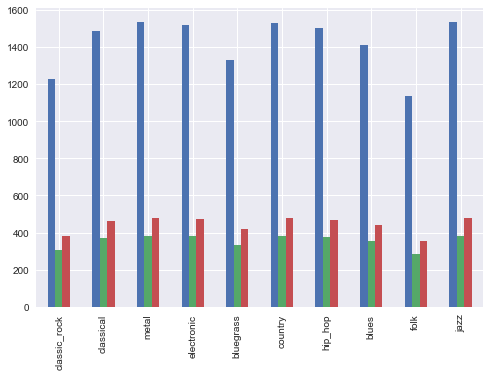

In [129]:
tt_split_dists.plot.bar(legend=False);

## Modeling

First run to compare with prior best performer

In [18]:
labels = list(df.genre.unique())

In [19]:
from sklearn.preprocessing import PowerTransformer
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from genres import eval_model
svc_model = SVC(
    C=10,
    gamma=0.25,
    probability=True,
)
svc = Pipeline([
    ('scaling', PowerTransformer()),
    ('model', svc_model)
])
svc.fit(X_train, y_train)
pred_probas = svc.predict_proba(X_test)
preds = svc.predict(X_test)
eval_model(y_test, preds, pred_probas, labels)


    Log Loss:
        0.5420860921319274
    Jaccard:
        0.72228
	-Country: 0.6179)
	-Jazz: 0.8381)
	-Hip_Hop: 0.64871)
	-Classical: 0.78231)
	-Metal: 0.73288)
	-Electronic: 0.63736)
	-Bluegrass: 0.81148)
	-Blues: 0.70892)
	-Folk: 0.73292)
	-Classic_Rock: 0.71221)


And what about it's competitor?

In [20]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.decomposition import PCA

In [21]:
# gbt_model = GradientBoostingClassifier(
#     max_depth=6,
#     n_estimators=200,
#     subsample=0.8,
# )
# gbt = Pipeline([
#     ('pca', PCA()),
#     ('model', gbt_model)
# ])
# gbt.fit(X_train, y_train)
# pred_probas = gbt.predict_proba(X_test)
# preds = gbt.predict(X_test)
# eval_model(y_test, preds, pred_probas, labels)

It still appears that Support Vectors are outperforming the tree models.

Perhaps dropping mfcc's 9 and 11 will help?

In [242]:
from sklearn_pandas import DataFrameMapper

In [253]:
mapper = DataFrameMapper(
    features=[
        (col, None) for col in X_train.columns if col not in ['mfcc9', 'mfcc11']
    ],
    df_out=True
)

In [274]:
svc.steps.insert(0, ('mapper', mapper))

In [277]:
svc.fit(X_train, y_train)
pred_probas = svc.predict_proba(X_test)
preds = svc.predict(X_test)
eval_model(y_test, preds, pred_probas, labels)


    Log Loss:
        0.6048032120083803
    Jaccard:
        0.69096
	-Country: 0.56468)
	-Jazz: 0.81132)
	-Hip_Hop: 0.6809)
	-Classical: 0.76941)
	-Metal: 0.67478)
	-Electronic: 0.63797)
	-Bluegrass: 0.7513)
	-Blues: 0.66362)
	-Folk: 0.67665)
	-Classic_Rock: 0.67898)


Well it performed worse. The support vectors were able to make sense of the features. A future experiment with even more mfcc's extracted may prove gainful.

#### Fine Tuning

In [32]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, log_loss

scorer = make_scorer(log_loss, greater_is_better=False, needs_proba=True)

In [39]:
params = {
    'model__C': [5,9,12,20],
    'model__gamma': [0.25, 2, 5, 'auto', 'scale'],
    'model__tol': [0.01, 0.001, 0.0001],
    'model__decision_function_shape': ['ovo', 'ovr']
}
svc_grid = GridSearchCV(
    estimator=svc,
    param_grid=params,
    n_jobs=-1,
    cv=5,
    error_score=np.nan,
    iid=True,
    scoring=scorer,
    pre_dispatch=8,
)
svc_grid.fit(X_train, y_train)

eval_model(
    y_test,
    svc_grid.predict(X_test),
    svc_grid.predict_proba(X_test),
    labels=labels
)


    Log Loss:
        0.5417384211671199
    Jaccard:
        0.721
	-Country: 0.61707)
	-Jazz: 0.8381)
	-Hip_Hop: 0.64871)
	-Classical: 0.78231)
	-Metal: 0.72893)
	-Electronic: 0.63596)
	-Bluegrass: 0.80926)
	-Blues: 0.70657)
	-Folk: 0.73292)
	-Classic_Rock: 0.71014)


In [41]:
svc_grid.best_params_

{'model__C': 9, 'model__gamma': 0.25, 'model__tol': 0.01}

Very little improvement over prior grid searches.

## Evaluation

In [57]:
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import confusion_matrix
plt.style.use('seaborn')

In [49]:
svc = svc_grid.best_estimator_
svc.fit(X_model, y_model)
pred_probas = svc.predict_proba(X_val)
preds = svc.predict(X_val)
eval_model(y_val, preds, pred_probas, labels)


    Log Loss:
        0.476540106698385
    Jaccard:
        0.74896
	-Country: 0.65398)
	-Jazz: 0.85605)
	-Hip_Hop: 0.68021)
	-Classical: 0.82375)
	-Metal: 0.73321)
	-Electronic: 0.67199)
	-Bluegrass: 0.8385)
	-Blues: 0.72727)
	-Folk: 0.76963)
	-Classic_Rock: 0.73502)


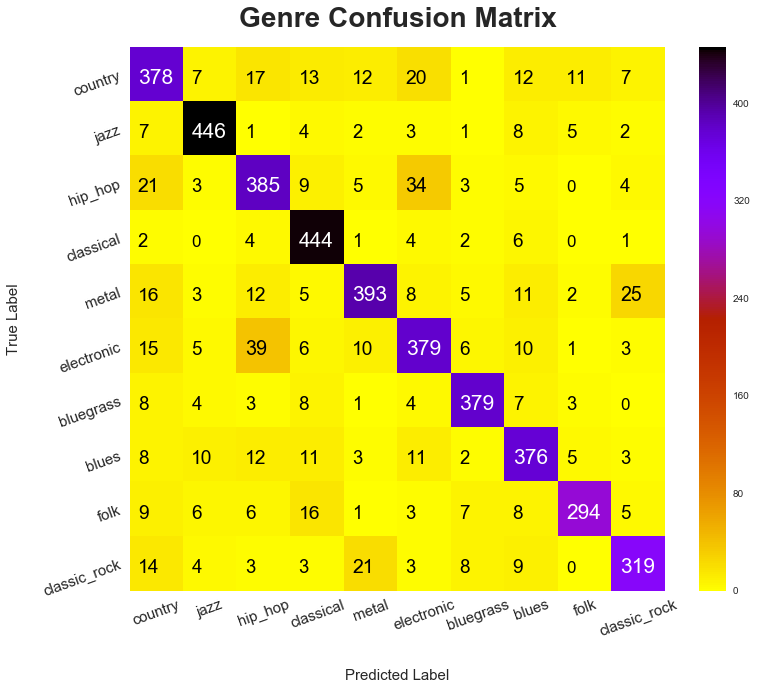

In [123]:
plt.figure(figsize=(12,10))
cm = confusion_matrix(y_val, preds, labels=labels)
n = len(cm)
size = 15
ax = sns.heatmap(cm, cmap='gnuplot_r')
ax.set_ylim(n,0)
ax.set_ylabel('True Label', labelpad=20, size=size)
ax.set_xlabel('Predicted Label', labelpad=30, size=size)
ax.set_xticklabels(labels, rotation=20, size=size)
ax.set_yticklabels(labels, rotation=20, size=size)
thresh = cm.max()/2
for i,j in itertools.product(range(n),range(n)):
    val = cm[i,j]
    plt.text(
        x=j+0.15,
        y=i+0.67,
        s=val,
        color='white' if val>thresh else 'black',
        size=18 + np.log(val + 0.1)/2
    )
plt.title(
    'Genre Confusion Matrix',
    pad=20,
    fontdict={'fontweight': 'bold', 'fontsize': 28}
);

In [81]:
from genres import percentify_cm

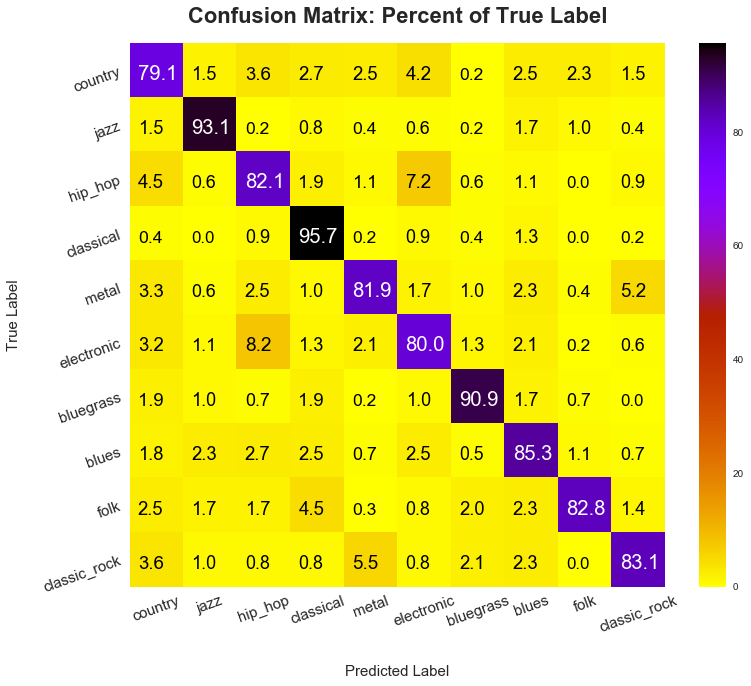

In [122]:
plt.figure(figsize=(12,10))
pcm = percentify_cm(cm)
size = 15
ax = sns.heatmap(pcm, cmap='gnuplot_r')
ax.set_ylim(n,0)
ax.set_ylabel('True Label', labelpad=20, size=size)
ax.set_xlabel('Predicted Label', labelpad=30, size=size)
ax.set_xticklabels(labels, rotation=20, size=size)
ax.set_yticklabels(labels, rotation=20, size=size)
thresh = pcm.max()/2
for i,j in itertools.product(range(n),range(n)):
    val = pcm[i,j]
    plt.text(
        x=j+0.15,
        y=i+0.67,
        s=val,
        color='white' if val>thresh else 'black',
        size=18 + np.log(val + 0.1)/2
    )
plt.title(
    'Confusion Matrix: Percent of True Label',
    pad=20,
    fontdict={'fontweight': 'bold', 'fontsize': 22}
);

Adding 4 classes did not diminish performance greatly. 😎   
Hip Hop and Electronic are still the most confused, similarly to the 6 genre model.
![](pcm_6genre.png)

 Metal and Classic rock are the next most commonly confused.

Jaccard Similarity of 0.75 is not much worse than the 6 genre model's 0.79
Log Loss of 0.48 is a fair bit higher than the 6 genre model's 0.38. The model is slightly less confident with so many classes to choose from.

## Deployment

In [ ]:
Pickling the 

In [124]:
with open('10genre_clf.pkl', 'wb') as f:
    pickle.dump(svc, f)